In [1]:
#Instalación de Kaggle
!pip install -q kaggle

In [2]:
from google.colab import files
#subir kaggle.json
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"erikamarlene","key":"2336a21daaa2f44411802d9434b732b3"}'}

In [3]:
#Configurar biblioteca de kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/kaggle.json #Colocamos el archivo en la carpeta
!chmod ~/.kaggle/kaggle.json 600 #Permiso 600 (lectura y escritura)

chmod: invalid mode: ‘/root/.kaggle/kaggle.json’
Try 'chmod --help' for more information.


# Problemática
Decidí usar un dataset de Kaggle con imágenes de 525 diferentes especies de aves. Usando MobileNetv2 Transfer Learning intentaré clasificar correctamente dichas imágenes de aves, mostrando los avances con una gráfica, predicciones y con la opción de subir una imagen que nunca ha visto.

In [4]:
# Descargar dataset
!kaggle datasets download -d gpiosenka/100-bird-species

100% 1.95G/1.96G [00:24<00:00, 154MB/s]
100% 1.96G/1.96G [00:24<00:00, 86.9MB/s]


In [5]:
#Unzip al archivo
!unzip 100-bird-species.zip -d '/content/kaggledb'

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: /content/kaggledb/train/WHITE TAILED TROPIC/120.jpg  
  inflating: /content/kaggledb/train/WHITE TAILED TROPIC/121.jpg  
  inflating: /content/kaggledb/train/WHITE TAILED TROPIC/122.jpg  
  inflating: /content/kaggledb/train/WHITE TAILED TROPIC/123.jpg  
  inflating: /content/kaggledb/train/WHITE TAILED TROPIC/124.jpg  
  inflating: /content/kaggledb/train/WHITE TAILED TROPIC/125.jpg  
  inflating: /content/kaggledb/train/WHITE TAILED TROPIC/126.jpg  
  inflating: /content/kaggledb/train/WHITE TAILED TROPIC/127.jpg  
  inflating: /content/kaggledb/train/WHITE TAILED TROPIC/128.jpg  
  inflating: /content/kaggledb/train/WHITE TAILED TROPIC/129.jpg  
  inflating: /content/kaggledb/train/WHITE TAILED TROPIC/130.jpg  
  inflating: /content/kaggledb/train/WHITE TAILED TROPIC/131.jpg  
  inflating: /content/kaggledb/train/WHITE TAILED TROPIC/132.jpg  
  inflating: /content/kaggledb/train/WHITE TAILED TROPIC/133.jpg  
 

## Preparando el dataset

Unifico las imágnes redimensionandolas y además selecciono un batch_size relativamente alto debido a la gran cantidad de imágenes que tiene el dataset. Separo las imágenes en train_dataset, test_dataset y validation_dataset. Uso AUTOTUNE para optimizar el desempeño de la carga de archivos. Tiene tanto original_train_dataset como train_dataset debido a problemas al usar prefetch de no ser así. Elegí un img_size de (128,128) para reducir el peso de las imágenes.

In [42]:
import tensorflow as tf

dataset_dir = './kaggledb/'

batch_size = 200
img_size = (128, 128)

AUTOTUNE = tf.data.AUTOTUNE

original_train_dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_dir + 'train',
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=batch_size,
    image_size=img_size,
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset='training'
)

original_validation_dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_dir + 'train',
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=batch_size,
    image_size=img_size,
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset='validation'
)

original_test_dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_dir + 'test',
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=batch_size,
    image_size=img_size,
    shuffle=False
)

class_names = original_train_dataset.class_names
print("Class names:", class_names)

train_dataset = original_train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = original_validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = original_test_dataset.prefetch(buffer_size=AUTOTUNE)

Found 84635 files belonging to 525 classes.
Using 67708 files for training.
Found 84635 files belonging to 525 classes.
Using 16927 files for validation.
Found 2625 files belonging to 525 classes.
Class names: ['ABBOTTS BABBLER', 'ABBOTTS BOOBY', 'ABYSSINIAN GROUND HORNBILL', 'AFRICAN CROWNED CRANE', 'AFRICAN EMERALD CUCKOO', 'AFRICAN FIREFINCH', 'AFRICAN OYSTER CATCHER', 'AFRICAN PIED HORNBILL', 'AFRICAN PYGMY GOOSE', 'ALBATROSS', 'ALBERTS TOWHEE', 'ALEXANDRINE PARAKEET', 'ALPINE CHOUGH', 'ALTAMIRA YELLOWTHROAT', 'AMERICAN AVOCET', 'AMERICAN BITTERN', 'AMERICAN COOT', 'AMERICAN DIPPER', 'AMERICAN FLAMINGO', 'AMERICAN GOLDFINCH', 'AMERICAN KESTREL', 'AMERICAN PIPIT', 'AMERICAN REDSTART', 'AMERICAN ROBIN', 'AMERICAN WIGEON', 'AMETHYST WOODSTAR', 'ANDEAN GOOSE', 'ANDEAN LAPWING', 'ANDEAN SISKIN', 'ANHINGA', 'ANIANIAU', 'ANNAS HUMMINGBIRD', 'ANTBIRD', 'ANTILLEAN EUPHONIA', 'APAPANE', 'APOSTLEBIRD', 'ARARIPE MANAKIN', 'ASHY STORM PETREL', 'ASHY THRUSHBIRD', 'ASIAN CRESTED IBIS', 'ASIAN DOL

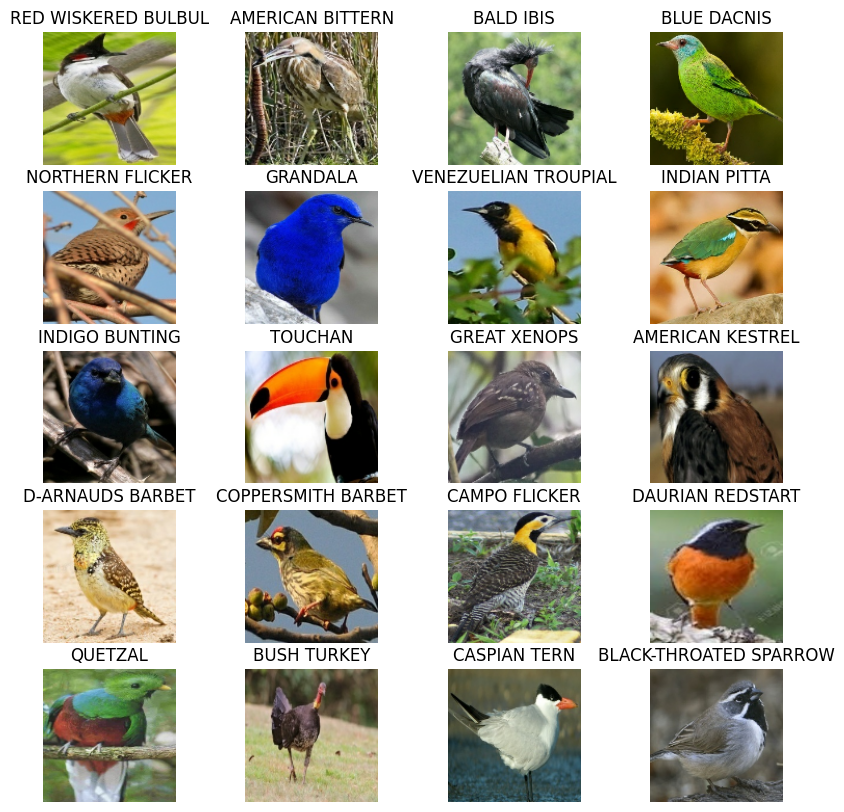

In [41]:
import matplotlib.pyplot as plt
images, labels = next(iter(train_dataset))

# Función para mostrar las imágenes de 20 categorías
def plot_images(images, labels):
    plt.figure(figsize=(10, 10))
    for i in range(20):
        ax = plt.subplot(5, 4, i + 1)
        img = images[i].numpy()
        plt.imshow(img.astype("uint8"))

        plt.title(class_names[labels[i]])
        plt.axis("off")

plot_images(images, labels)

## Primer intento

En este primer intento decidí usar MobileNetV2 sin tener mucho conocimiento al respecto, poniendo que no sea entrenable entre otras características.

In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam


base_model = MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet')

base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

9406464/9406464 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Func  (None, 4, 4, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 525)               134925    
                                                           

In [16]:
import pickle
# Entrenando el modelo
epochs = 20
AUTOTUNE = tf.data.AUTOTUNE
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    train_dataset,
    validation_data = validation_dataset,
    epochs=epochs,
    callbacks = [early_stopping]
)
# Guardando el historial de training en un archivo
history_path = '/content/training_history.pkl'
with open(history_path, 'wb') as file:
    pickle.dump(history.history, file)

Epoch 1/10
339/339 [==============================] - 71s 204ms/step - loss: 6.2018 - accuracy: 0.0041 - val_loss: 6.1617 - val_accuracy: 0.0075
Epoch 2/10
339/339 [==============================] - 70s 203ms/step - loss: 6.1637 - accuracy: 0.0051 - val_loss: 6.0760 - val_accuracy: 0.0085
Epoch 3/10
339/339 [==============================] - 62s 182ms/step - loss: 6.1095 - accuracy: 0.0066 - val_loss: 6.0075 - val_accuracy: 0.0108
Epoch 4/10
339/339 [==============================] - 63s 183ms/step - loss: 6.0599 - accuracy: 0.0070 - val_loss: 5.9374 - val_accuracy: 0.0143
Epoch 5/10
339/339 [==============================] - 65s 189ms/step - loss: 6.0118 - accuracy: 0.0088 - val_loss: 5.8776 - val_accuracy: 0.0171
Epoch 6/10
339/339 [==============================] - 75s 218ms/step - loss: 5.9676 - accuracy: 0.0096 - val_loss: 5.8249 - val_accuracy: 0.0196
Epoch 7/10
339/339 [==============================] - 82s 239ms/step - loss: 5.9245 - accuracy: 0.0115 - val_loss: 5.7536 - val_ac

In [17]:
# Evaluando el modelo con el set de test
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f'Test accuracy: {test_accuracy * 100:.2f}%')

14/14 [==============================] - 3s 176ms/step - loss: 5.5760 - accuracy: 0.0335
Test accuracy: 3.35%


Usando early stopping se puede notar que terminó en la época 10 y que tuvo un pésimo desempeño. El modelo tiene un accuracy de 3.35%

## Segundo intento

In [27]:
import keras
from keras import layers
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import Sequential
#from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.callbacks import ModelCheckpoint

import warnings
warnings.filterwarnings('ignore')

De igual manera estoy usando MobileNetV2, el base model es el mismo

In [22]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam


base_model = MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet')

mn_layers = len(base_model.layers)

9406464/9406464 [==============================] - 0s 0us/step


Al inicio se configura para que excluya la capa top

In [23]:
base_model.trainable = True

print('¡Configurando las últimas {} capas en el modelo base de red móvil para que sean entrenables!\n'.format(0))

for mn_layer in base_model.layers[:-0]:
    mn_layer.trainable = False

trainableParams = np.sum([np.prod(v.get_shape()) for v in base_model.trainable_weights])
nonTrainableParams = np.sum([np.prod(v.get_shape()) for v in base_model.non_trainable_weights])
totalParams = trainableParams + nonTrainableParams

print('El número de parámetros entrenables en el Mobile Net V2 Base Model es {}.'.format(trainableParams))
print('El número de parámetros no entrenables en el  Mobile Net V2 Base Model es {}.'.format(nonTrainableParams))
print('El número total de parametros es {}.'.format(totalParams))

¡Configurando las últimas 0 capas en el modelo base de red móvil para que sean entrenables!

El número de parámetros entrenables en el Mobile Net V2 Base Model es 2223872.
El número de parámetros no entrenables en el  Mobile Net V2 Base Model es 34112.
El número total de parametros es 2257984.


Al inicio congela todas las capas manteniendo los pesos iniciales sin cambiar, de esta manera como tenemos un modelo pre-entrenado podemos sacar provecho de las features generales que ya ha aprendido y hacerle fine-tunning a lo demás.

## **Construcción del Modelo**
Mobile Net V2 Base → 3 Dense Layers resultando en Softmax Output

Después de usar MobileNetV2 se agregaron otras capas para maximizar los resultados y que el modelo aprenda

In [44]:
# start model with input shape equal to image shape
inputs = tf.keras.Input(shape = (128, 128, 3))
# apply through mobile net v2 base
x = base_model(inputs)
# global average pool to collapse to 1D
x = layers.GlobalAveragePooling2D()(x)
# normalize layer
x = layers.BatchNormalization()(x)
# apply relu activation
x = layers.ReLU()(x)
# include dropout with probability of 0.2 to avoid overfitting
x = layers.Dropout(0.25)(x)
# densely connected layer with 2000
x = layers.Dense(1500)(x)
# normalize layer
x = layers.BatchNormalization()(x)
# apply relu activation
x = layers.ReLU()(x)
# include dropout with probability of 0.2 to avoid overfitting
x = layers.Dropout(0.25)(x)
# densely connected output layer with same number of output classes
x = layers.Dense(1200)(x)
# normalize layer
x = layers.BatchNormalization()(x)
# apply relu activation
x = layers.ReLU()(x)
# include dropout with probability of 0.2 to avoid overfitting
x = layers.Dropout(0.25)(x)
# densely connected output layer with same number of output classes
x = layers.Dense(900)(x)
# normalize layer
x = layers.BatchNormalization()(x)
# apply relu activation
x = layers.ReLU()(x)
# include dropout with probability of 0.2 to avoid overfitting
x = layers.Dropout(0.25)(x)
# densely connected output layer with same number of output classes
outputs = layers.Dense(525, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 mobilenetv2_1.00_128 (Func  (None, 4, 4, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_3  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 batch_normalization_12 (Ba  (None, 1280)              5120      
 tchNormalization)                                               
                                                                 
 re_lu_8 (ReLU)              (None, 1280)              0         
                                                           

## Ronda 1 de entrenamiento:
Estoy usando ModelCheckpoint para guardar los mejores pesos con base en la precisión de validación.

In [45]:
optimizer_1 = tf.keras.optimizers.Adam(learning_rate = 0.001)

loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)

model_checkpoint = ModelCheckpoint(filepath='./Bird-Classifier-Model-Checkpoint.ckpt',
                                   monitor='val_accuracy',
                                   save_best_only=True,
                                   save_weights_only=True,
                                   verbose=1,
                                   mode = 'max')

callbacks = [model_checkpoint]

model.compile(optimizer = optimizer_1,
              loss = loss,
              metrics=['accuracy'])

In [47]:
history = model.fit(train_dataset,
                    validation_data=validation_dataset,
                    epochs=10,
                    callbacks = callbacks)

Epoch 1/10
339/339 [==============================] - ETA: 0s - loss: 2.6936 - accuracy: 0.4373
Epoch 1: val_accuracy improved from -inf to 0.11981, saving model to ./Bird-Classifier-Model-Checkpoint.ckpt
339/339 [==============================] - 152s 352ms/step - loss: 2.6936 - accuracy: 0.4373 - val_loss: 4.7708 - val_accuracy: 0.1198
Epoch 2/10
339/339 [==============================] - ETA: 0s - loss: 0.9381 - accuracy: 0.7503
Epoch 2: val_accuracy did not improve from 0.11981
339/339 [==============================] - 116s 340ms/step - loss: 0.9381 - accuracy: 0.7503 - val_loss: 7.3525 - val_accuracy: 0.0519
Epoch 3/10
339/339 [==============================] - ETA: 0s - loss: 0.6443 - accuracy: 0.8217
Epoch 3: val_accuracy did not improve from 0.11981
339/339 [==============================] - 116s 340ms/step - loss: 0.6443 - accuracy: 0.8217 - val_loss: 9.0203 - val_accuracy: 0.0473
Epoch 4/10
339/339 [==============================] - ETA: 0s - loss: 0.5031 - accuracy: 0.8571


Se pueden observar muy buenos resultados en la primera fase

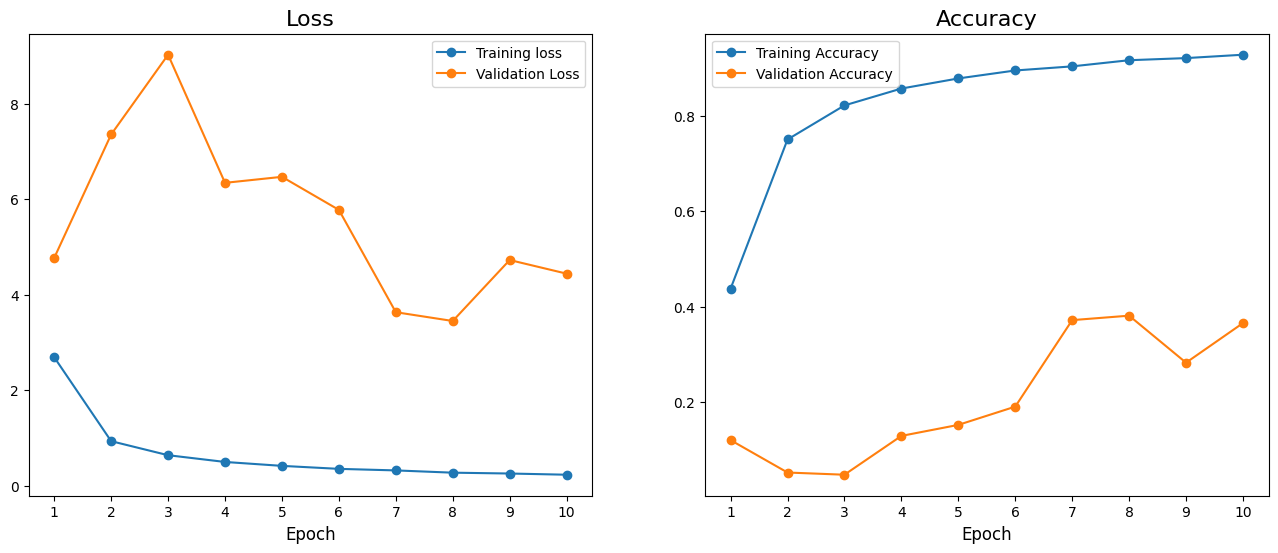

In [57]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))
title_fontsize = 16
axis_fontsize = 12

total_epochs = 10

ax1.plot(range(1, total_epochs + 1), history.history['loss'], marker='o', label='Training loss')
ax1.plot(range(1, total_epochs + 1), history.history['val_loss'], marker='o', label='Validation Loss')
ax1.legend()
ax1.set_xticks(range(1, total_epochs + 1))
ax1.set_title('Loss', fontsize=title_fontsize)
ax1.set_xlabel('Epoch', fontsize=axis_fontsize)

ax2.plot(range(1, total_epochs + 1), history.history['accuracy'], marker='o', label='Training Accuracy')
ax2.plot(range(1, total_epochs + 1), history.history['val_accuracy'], marker='o', label='Validation Accuracy')
ax2.legend()
ax2.set_xticks(range(1, total_epochs + 1))
ax2.set_title('Accuracy', fontsize=title_fontsize)
ax2.set_xlabel('Epoch', fontsize=axis_fontsize);

Al momento de graficar la Pérdida se observa overfitting, el modelo está aprendiendo patrones de los datos de entrenamineto y no funciona bien ante información que no ha visto.

En la gráfica de Accuracy se puede observar que está muy baja y que tiene ciertos altos y bajos, sustentando lo que mencioné del overfitting.

In [49]:
model.load_weights('./Bird-Classifier-Model-Checkpoint.ckpt')

test_loss, test_accuracy = model.evaluate(test_dataset)

print('\n\033[1m' + 'El modelo tiene un porcentaje de exactitud de {}%!!'.format(round(100*test_accuracy,1)) + '\033[0m')

14/14 [==============================] - 2s 130ms/step - loss: 2.8333 - accuracy: 0.4381

El modelo tiene un porcentaje de exactitud de 43.8%!!


Además podemos observar que en Test Accuracy el porcentaje es malo, siendo menor a 50%

7/7 [==============================] - 3s 65ms/step


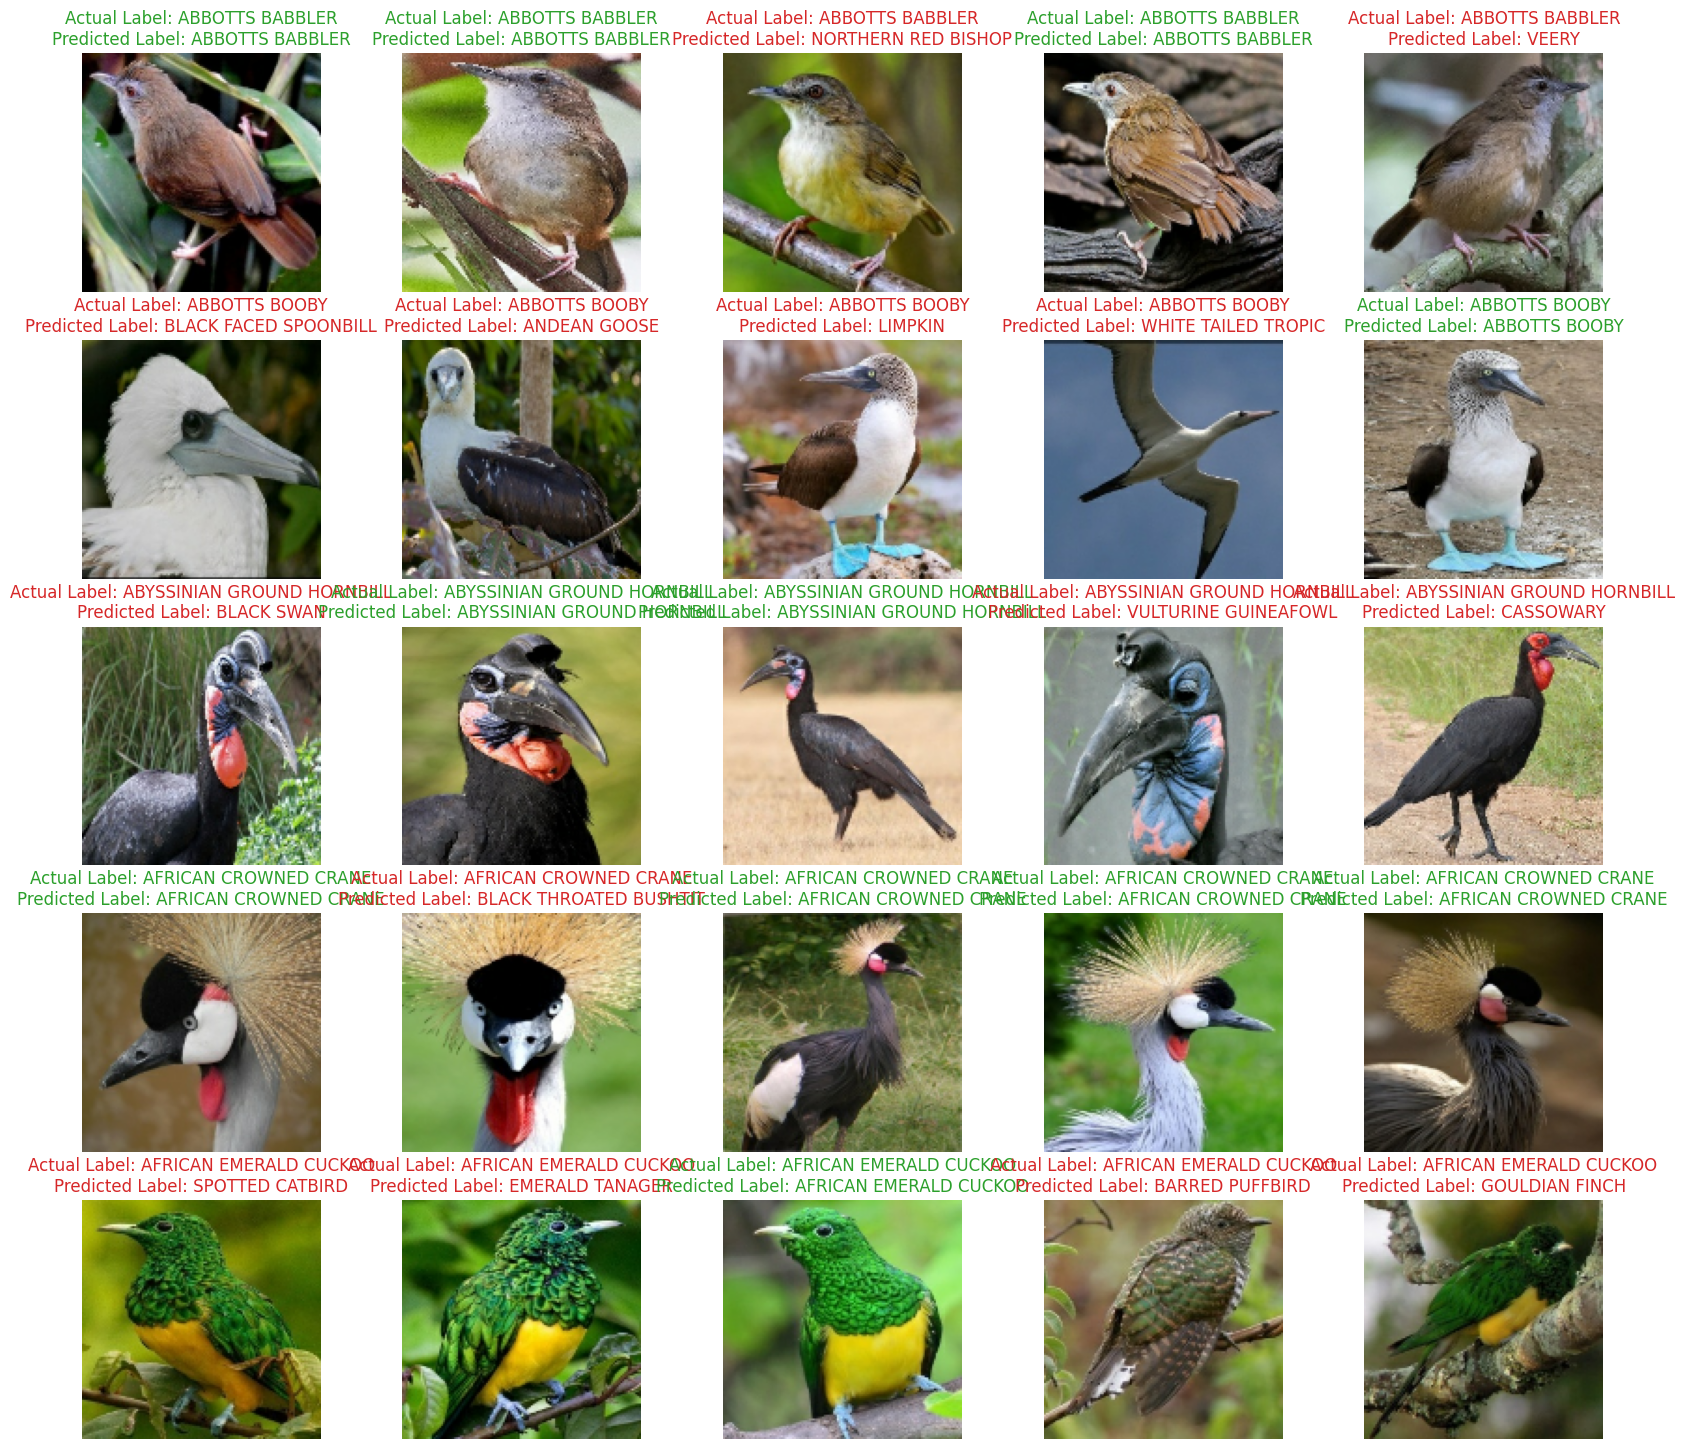

In [53]:
plt.figure(figsize=(20, 18))

for images, labels in test_dataset.take(1):
    guesses = np.argmax(model.predict(images), axis=1)
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        if guesses[i] == np.argmax(labels[i]):
            color = 'tab:green'
        else:
            color = 'tab:red'
        plt.title('Actual Label: {}\nPredicted Label: {}'.format(
                            class_names[np.argmax(labels[i])], class_names[guesses[i]]),
                 color = color)
        plt.axis("off")

Mostrando lo que "cree" que es vs lo que realmente es podemos observar que está teniendo problemas y se equivoca.  

## Entrenamiento de siguientes capas

In [62]:
model.layers[1].trainable = True

print('¡Configuración de las últimas {} capas de Mobile Net Base Model a entrenables!'.format(38))

for layer in model.layers[1].layers[:-38]:
    layer.trainable = False

¡Configuración de las últimas 38 capas de Mobile Net Base Model a entrenables!


En la siguiente parte del entrenamiento congela todas las capas manteniendo los pesos iniciales sin cambiar excepto por las últimas 38 capas, de esta manera podemos hacerle fine-tunning a estas últimas capas.

In [63]:
optimizer_2 = tf.keras.optimizers.Adam(learning_rate = 0.001 * 0.2)

callbacks = [model_checkpoint, model.history]

model.compile(optimizer = optimizer_2,
              loss = loss,
              metrics=['accuracy'])

Ahora el learning_rate es más pequeño, callbacks para seguir guardando los mejores pesos y el history del modelo al momento

In [64]:
history = model.fit(train_dataset,
                    validation_data=validation_dataset,
                    epochs=10,
                    callbacks = callbacks)

Epoch 1/10
339/339 [==============================] - ETA: 0s - loss: 0.2704 - accuracy: 0.9197
Epoch 1: val_accuracy improved from 0.38081 to 0.67844, saving model to ./Bird-Classifier-Model-Checkpoint.ckpt
339/339 [==============================] - 95s 249ms/step - loss: 0.2704 - accuracy: 0.9197 - val_loss: 1.5268 - val_accuracy: 0.6784
Epoch 2/10
339/339 [==============================] - ETA: 0s - loss: 0.1380 - accuracy: 0.9581
Epoch 2: val_accuracy improved from 0.67844 to 0.78130, saving model to ./Bird-Classifier-Model-Checkpoint.ckpt
339/339 [==============================] - 93s 270ms/step - loss: 0.1380 - accuracy: 0.9581 - val_loss: 1.0135 - val_accuracy: 0.7813
Epoch 3/10
339/339 [==============================] - ETA: 0s - loss: 0.0898 - accuracy: 0.9735
Epoch 3: val_accuracy improved from 0.78130 to 0.83848, saving model to ./Bird-Classifier-Model-Checkpoint.ckpt
339/339 [==============================] - 87s 249ms/step - loss: 0.0898 - accuracy: 0.9735 - val_loss: 0.71

Se puede observar que el accuracy es muy bueno

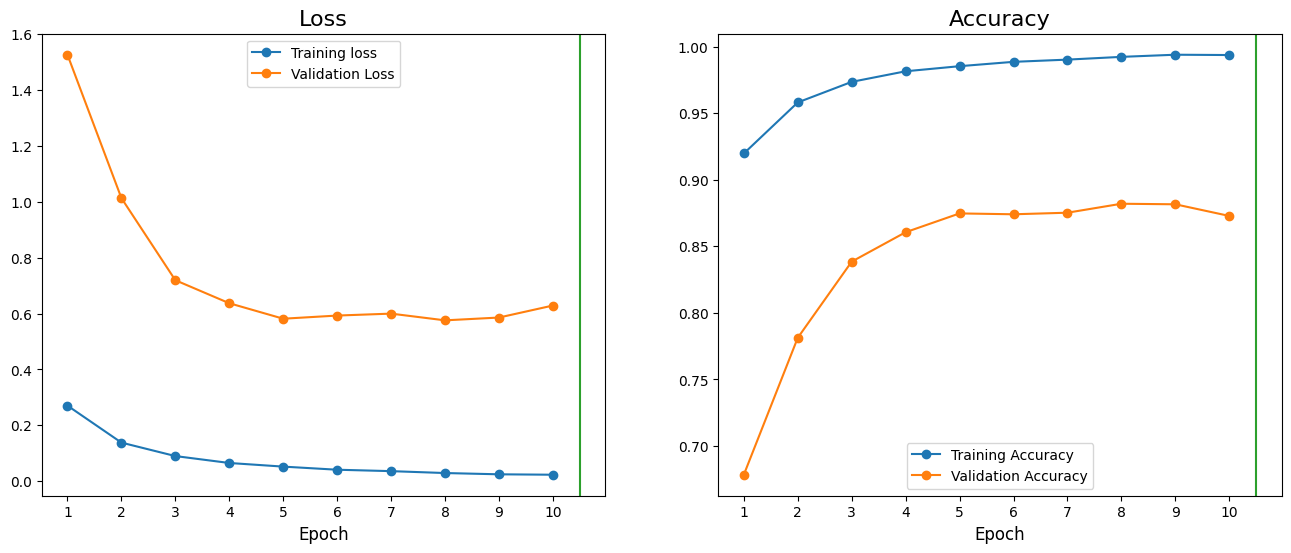

In [80]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))
title_fontsize = 16
axis_fontsize = 12

total_epochs = 10
new_rounds = [10 + 0.5]

ax1.plot(range(1, total_epochs + 1), history.history['loss'], marker='o', label='Training loss')
ax1.plot(range(1, total_epochs + 1), history.history['val_loss'], marker='o', label='Validation Loss')
ax1.legend()
ax1.set_xticks(range(1, total_epochs + 1))
ax1.set_title('Loss', fontsize=title_fontsize)
ax1.set_xlabel('Epoch', fontsize=axis_fontsize)

ax2.plot(range(1, total_epochs + 1), history.history['accuracy'], marker='o', label='Training Accuracy')
ax2.plot(range(1, total_epochs + 1), history.history['val_accuracy'], marker='o', label='Validation Accuracy')
ax2.legend()
ax2.set_xticks(range(1, total_epochs + 1))
ax2.set_title('Accuracy', fontsize=title_fontsize)
ax2.set_xlabel('Epoch', fontsize=axis_fontsize)

for new_round in new_rounds:
    ax1.axvline(new_round, c='tab:green')
    ax2.axvline(new_round, c='tab:green');

**Se observan grandes mejoras donde ya no hay overfitting!**

## Último entrenamiento de siguientes capas

In [86]:
model.layers[1].trainable = True

print('¡Configuración de las últimas {} capas de Mobile Net V2 Base Model a entrenables!'.format(74))

for layer in model.layers[1].layers[:-74]:
    layer.trainable = False

¡Configuración de las últimas 74 capas de Mobile Net Base Model a entrenables!


Ahora es aún más pequeño el learning rate

In [87]:
optimizer_3 = tf.keras.optimizers.Adam(learning_rate = 0.001 * 0.2 * 0.2)

callbacks = [model_checkpoint, model.history]

model.compile(optimizer = optimizer_3,
              loss = loss,
              metrics=['accuracy'])

In [88]:
history = model.fit(train_dataset,
                    validation_data=validation_dataset,
                    epochs=10,
                    callbacks = callbacks)

Epoch 1/10
339/339 [==============================] - ETA: 0s - loss: 0.0263 - accuracy: 0.9921
Epoch 1: val_accuracy improved from 0.88196 to 0.89213, saving model to ./Bird-Classifier-Model-Checkpoint.ckpt
339/339 [==============================] - 100s 250ms/step - loss: 0.0263 - accuracy: 0.9921 - val_loss: 0.5424 - val_accuracy: 0.8921
Epoch 2/10
339/339 [==============================] - ETA: 0s - loss: 0.0170 - accuracy: 0.9953
Epoch 2: val_accuracy improved from 0.89213 to 0.89726, saving model to ./Bird-Classifier-Model-Checkpoint.ckpt
339/339 [==============================] - 86s 250ms/step - loss: 0.0170 - accuracy: 0.9953 - val_loss: 0.5220 - val_accuracy: 0.8973
Epoch 3/10
339/339 [==============================] - ETA: 0s - loss: 0.0128 - accuracy: 0.9970
Epoch 3: val_accuracy improved from 0.89726 to 0.90235, saving model to ./Bird-Classifier-Model-Checkpoint.ckpt
339/339 [==============================] - 85s 249ms/step - loss: 0.0128 - accuracy: 0.9970 - val_loss: 0.5

Se vuelven a observar excelentes valores en accuracy y mejoraron los de val_accuracy

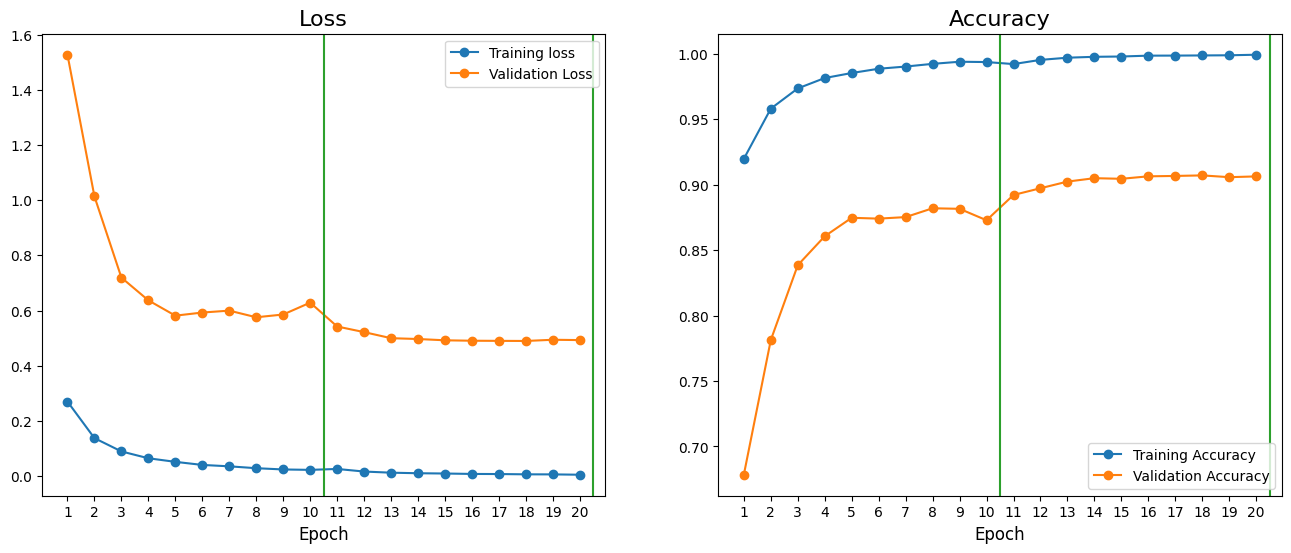

In [89]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))
title_fontsize = 16
axis_fontsize = 12

total_epochs += 10
new_rounds += [10 + 10 + 0.5]

ax1.plot(range(1, total_epochs + 1), history.history['loss'], marker='o', label='Training loss')
ax1.plot(range(1, total_epochs + 1), history.history['val_loss'], marker='o', label='Validation Loss')
ax1.legend()
ax1.set_xticks(range(1, total_epochs + 1))
ax1.set_title('Loss', fontsize=title_fontsize)
ax1.set_xlabel('Epoch', fontsize=axis_fontsize)

ax2.plot(range(1, total_epochs + 1), history.history['accuracy'], marker='o', label='Training Accuracy')
ax2.plot(range(1, total_epochs + 1), history.history['val_accuracy'], marker='o', label='Validation Accuracy')
ax2.legend()
ax2.set_xticks(range(1, total_epochs + 1))
ax2.set_title('Accuracy', fontsize=title_fontsize)
ax2.set_xlabel('Epoch', fontsize=axis_fontsize);

for new_round in new_rounds:
    ax1.axvline(new_round, c='tab:green')
    ax2.axvline(new_round, c='tab:green');

Esta gráfica muestra las últimas 20 épocas y se pueden obserar mejoras, las pérdidas van bajando y accuracy aumenta. Ambas muestran un comportamiento estable.

In [90]:
model.load_weights('./Bird-Classifier-Model-Checkpoint.ckpt')

test_loss, test_accuracy = model.evaluate(test_dataset)

print('\n\033[1m' + 'El modelo 2 tiene un porcentaje de exactitud de {}%!!'.format(round(100*test_accuracy,1)) + '\033[0m')

14/14 [==============================] - 2s 142ms/step - loss: 0.1312 - accuracy: 0.9650

El modelo 2 tiene un porcentaje de exactitud de 96.5%!!


**Checando los pesos se puede observar una increíble mejora en el porcentaje de Accuracy, siendo de 96 %**

7/7 [==============================] - 1s 22ms/step


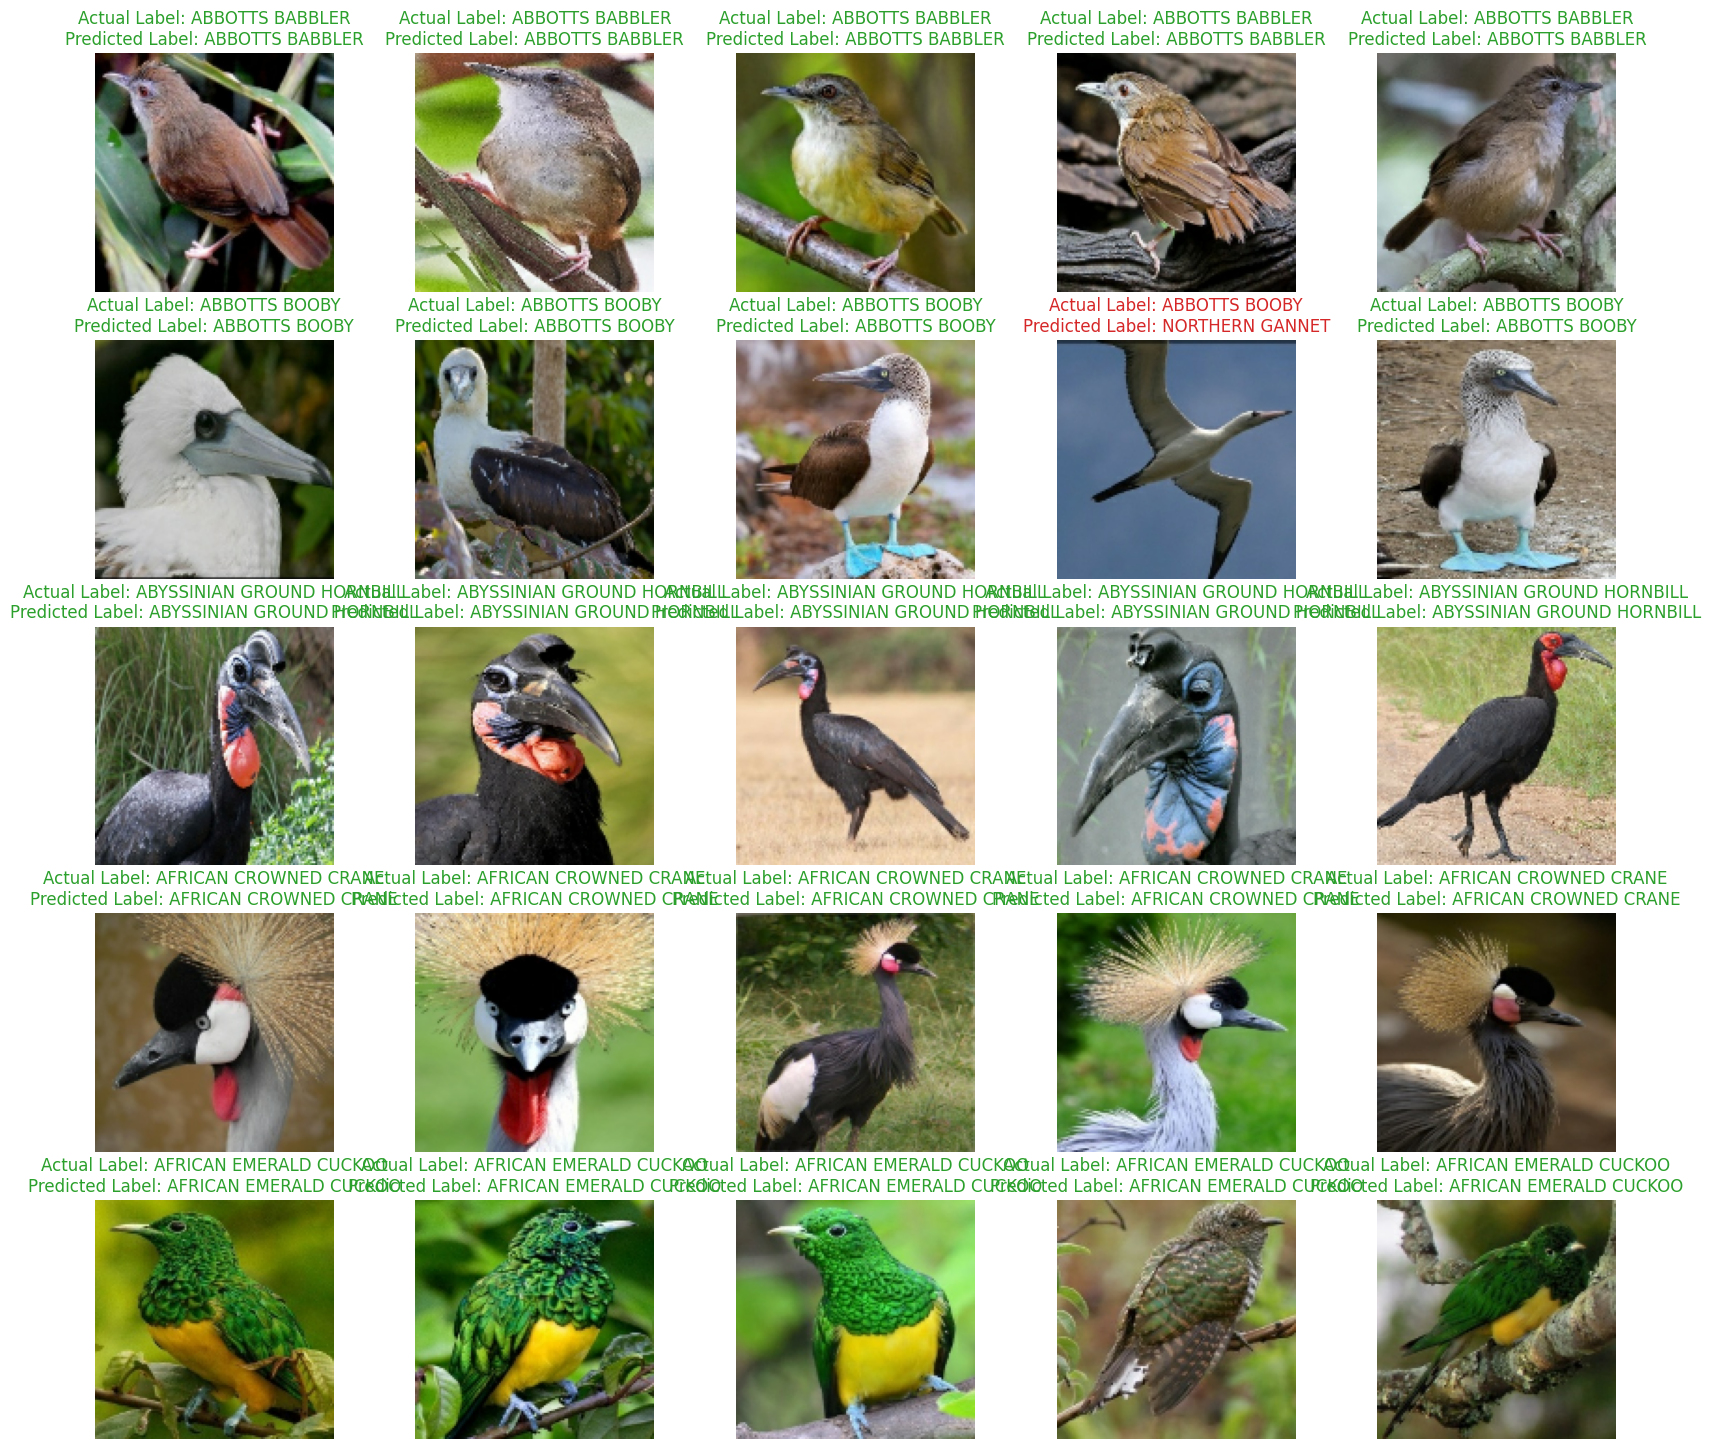

In [91]:
plt.figure(figsize=(20, 18))

for images, labels in test_dataset.take(1):
    guesses = np.argmax(model.predict(images), axis=1)
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        if guesses[i] == np.argmax(labels[i]):
            color = 'tab:green'
        else:
            color = 'tab:red'
        plt.title('Actual Label: {}\nPredicted Label: {}'.format(
                            class_names[np.argmax(labels[i])], class_names[guesses[i]]),
                 color = color)
        plt.axis("off")

De 25 predicciones podemos observar que solo se equivoca en 1!

Saving 3.jpg to 3 (2).jpg
Se subió correctamente el archivo "3 (2).jpg"
1/1 [==============================] - 1s 891ms/step


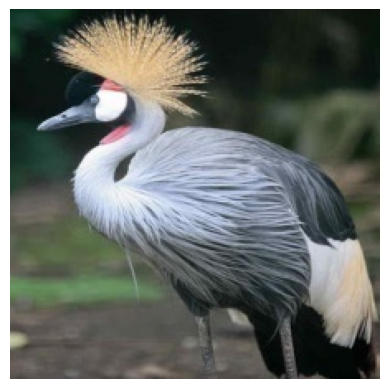

Clase predicha: AFRICAN CROWNED CRANE


In [92]:
from keras.preprocessing import image
from google.colab import files


def predict_image(img_path, model):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)
    predicted_class_name = class_names[predicted_class[0]]

    return predicted_class_name, img

uploaded = files.upload()

for fn in uploaded.keys():
    print('Se subió correctamente el archivo "{name}"'.format(name=fn))
    predicted_class, img = predict_image(fn, model)

    plt.imshow(img)
    plt.axis('off')
    plt.show()
    print('Clase predicha:', predicted_class)


Por último aquí hay un apartado para subir la imagen que deseen y comprobar si la predición es correcta.

## Conclusión
Pude aprender que es notable la diferencia de usar un modelo pre-entrenado con pocas capas y sin tener un amplio conocimiento de como usarlo a empaparse con la documentación y probar con muchas más capas adicionales al modelo de transfer-learning.